In [29]:
import pandas as pd
import datetime
from tqdm import tqdm
import re
import optuna
import operator
import numpy as np
import matplotlib.pyplot as plt
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)
import numpy as np
import pandas as pd
import scipy.stats as stats
import sklearn
from sklearn.model_selection import train_test_split
import requests
from datetime import timedelta
import pickle
from sklearn.linear_model import LinearRegression

<IPython.core.display.Javascript object>

In [30]:
def test_live(sample_duration):
    def vn30f():
        return requests.get("https://services.entrade.com.vn/chart-api/chart?from=1651727820&resolution=1&symbol=VN30F1M&to=9999999999").json()
    vn30fm = pd.DataFrame(vn30f()).iloc[:,:6]
    vn30fm['t'] = vn30fm['t'].astype(int).apply(lambda x: datetime.datetime.utcfromtimestamp(x) + timedelta(hours = 7))
    vn30fm.columns = ['Date','Open','High','Low','Close','Volume']
    s = pd.read_csv('C:\python\VN30F1M.csv')
    s['Date'] = pd.to_datetime(s['Date']) + timedelta(hours =7)
    ohlc_dict = {                                                                                                             
        'Open': 'first',                                                                                                    
        'High': 'max',                                                                                                       
        'Low': 'min',                                                                                                        
        'Close': 'last',                                                                                                    
        'Volume': 'sum',}
    vn30fm = pd.DataFrame(vn30f()).iloc[:,:6]
    vn30fm['t'] = vn30fm['t'].astype(int).apply(lambda x: datetime.datetime.utcfromtimestamp(x) + timedelta(hours = 7))
    vn30fm.columns = ['Date','Open','High','Low','Close','Volume']
    def process_data(input_df):
        vn30train = pd.DataFrame(input_df.resample(str(sample_duration)+'Min', on='Date', label='left').apply(ohlc_dict).dropna()).reset_index()#change s
        vn30train['Date'] = [str(i)[:16] for i in vn30train['Date']]
        return vn30train
    vn30f_base = pd.concat([process_data(vn30fm), process_data(s)]).sort_values('Date').drop_duplicates('Date').sort_values('Date')
    return vn30f_base

In [38]:
data = test_live(15)

def create_ds(data):
    data.Date = pd.to_datetime(data.Date)
    dff = data[['Date', 'Open']]
    #dff['Date'] = pd.to_datetime(dff['Date'])
    dff['Date'].apply(lambda x:x.hour)
    df1 = dff.loc[(dff['Date'].apply(lambda x:x.minute)==00)&(dff['Date'].apply(lambda x:x.hour)==9)]
    df1.Date = [str(i)[:10] for i in df1.Date]

    df = data[['Date', 'Close']]
    #df['Date'] = pd.to_datetime(df['Date'])
    df['Date'].apply(lambda x:x.hour)
    df2 = df.loc[(df['Date'].apply(lambda x:x.minute)==15)&(df['Date'].apply(lambda x:x.hour)==9)]
    df2.Date = [str(i)[:10] for i in df2.Date]
    #df 9:30
    df3 = df.loc[(df['Date'].apply(lambda x:x.minute)==30)&(df['Date'].apply(lambda x:x.hour)==9)]
    df3.Date = [str(i)[:10] for i in df3.Date]
    #df 10:00
    df4 = df.loc[(df['Date'].apply(lambda x:x.minute)==00)&(df['Date'].apply(lambda x:x.hour)==10)]
    df4.Date = [str(i)[:10] for i in df4.Date]
    #ds
    ds = df1.merge(df2, how = 'inner', on = 'Date').merge(df3, how = 'inner', on = 'Date').merge(df4, how = 'inner', on = 'Date')
    ds.columns = ['Date', 'Open', '9:15', '9:30', '10:00']
    # find_low to merge to ds
    df10 = data[['Date', 'Low']]
    df10['Date'] = pd.to_datetime(df10['Date'])
    findlow = df10.loc[(df10['Date'].apply(lambda x:x.hour)>10)]
    findlow['Day'] = [str(i)[:10] for i in findlow.Date]
    data['Day'] = [str(i)[:10] for i in data.Date]
    low = findlow[['Day','Low']].groupby('Day').min()
    #high = data[['Day','High']].groupby('Day').max()
    #high['Date'] = high.index
    df11 = data[['Date', 'High']]
    df11['Date'] = pd.to_datetime(df10['Date'])
    findhigh = df11.loc[(df11['Date'].apply(lambda x:x.hour)>10)]
    findhigh['Day'] = [str(i)[:10] for i in findhigh.Date]
    data['Day'] = [str(i)[:10] for i in data.Date]
    high = findhigh[['Day','High']].groupby('Day').max()

    low['Date'] = low.index
    high['Date'] = high.index
    return ds, low, high
dss, low, high = create_ds(data)

C:\Users\Admin\AppData\Local\Temp\ipykernel_6004\3820258217.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.Date = [str(i)[:10] for i in df1.Date]
C:\Users\Admin\AppData\Local\Temp\ipykernel_6004\3820258217.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.Date = [str(i)[:10] for i in df2.Date]
C:\Users\Admin\AppData\Local\Temp\ipykernel_6004\3820258217.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [39]:
ds = dss.merge(low, how='left', on='Date')
ds1 = dss.merge(high, how = 'left', on = 'Date')

In [40]:
len(ds)

1329

Text(0.5, 1.0, 'Prices vs Predicted prices: $Y_i$ vs $\\hat{Y}_i$')

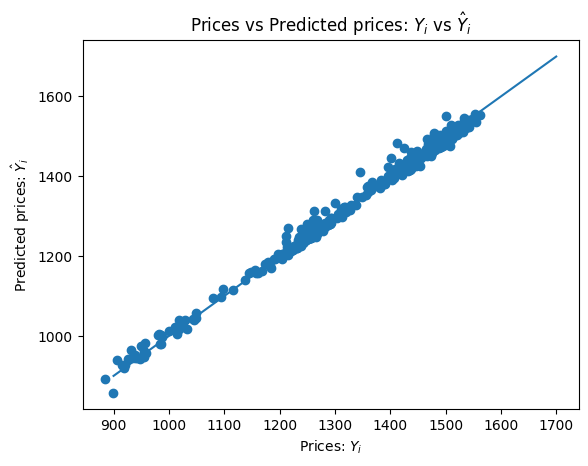

In [41]:
def create_XY(ds):
    X = ds.drop(['Low', 'Date'], axis = 1)
    Y = ds['Low']
    X_train = X.loc[:900]
    X_test = X.loc[900:]
    Y_train = Y.loc[:900]
    Y_test = Y.loc[900:]
    return X_train, Y_train, X_test, Y_test
X_train, Y_train, X_test, Y_test = create_XY(ds)

def create_XY1(ds1):
    X = ds1.drop(['High', 'Date'], axis = 1)
    Y = ds1['High']
    X_train = X.loc[:900]
    X_test = X.loc[900:]
    Y_train = Y.loc[:900]
    Y_test = Y.loc[900:]
    return X_train, Y_train, X_test, Y_test
X_train1, Y_train1, X_test1, Y_test1 = create_XY1(ds1)

lm = pickle.load(open('finalized_model.sav', 'rb'))
Y_pred = lm.predict(X_test)
x = np.linspace(900, 1700, 100000)
plt.plot(x, x)
plt.scatter(Y_test, Y_pred)
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")

Text(0.5, 1.0, 'Prices vs Predicted prices: $Y_i$ vs $\\hat{Y}_i$')

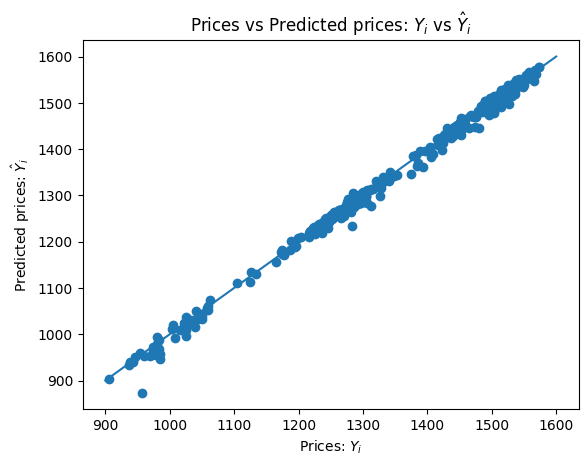

In [42]:
from sklearn.linear_model import LinearRegression

lm1 = LinearRegression()
lm1.fit(X_train1, Y_train1)

Y_pred1 = lm1.predict(X_test1)
x = np.linspace(900, 1600, 100000)
plt.plot(x, x)
plt.scatter(Y_test1, Y_pred1)
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")

In [43]:
Y_pred1

array([1209.99360019, 1200.92456813, 1182.92434246, 1170.74175018,
       1172.88272575, 1181.49776465, 1187.77762458, 1207.52526831,
       1218.60234662, 1251.29906689, 1257.89750604, 1260.01974202,
       1257.83434841, 1257.44605557, 1255.6456212 , 1264.76744624,
       1304.68605582, 1285.58444725, 1292.90053952, 1292.20568725,
       1277.25186358, 1332.69934903, 1307.12729015, 1284.25743155,
       1297.20894624, 1266.01679418, 1285.59040391, 1297.39285159,
       1298.48058579, 1343.42898632, 1339.98199827, 1338.38100702,
       1346.65091488, 1369.92024554, 1363.87830068, 1387.28564781,
       1396.24039299, 1384.9615354 , 1384.69476143, 1389.39781347,
       1413.71391875, 1416.2468769 , 1430.35987767, 1433.47096793,
       1447.6644246 , 1460.91720766, 1445.161922  , 1444.89220073,
       1487.2517179 , 1502.40918571, 1494.86991618, 1515.93859198,
       1504.03931929, 1503.53705229, 1448.55881169, 1474.50036993,
       1473.34842329, 1504.58598273, 1499.44130506, 1479.56660

In [44]:
Y_pred

array([1192.47893379, 1184.62598471, 1165.95074076, 1156.83774034,
       1158.58523956, 1163.31216266, 1170.75416467, 1192.75316794,
       1203.95408887, 1232.36411758, 1244.95078732, 1243.50244719,
       1242.82451196, 1241.47371503, 1239.40301435, 1248.13228306,
       1290.49598798, 1269.51786789, 1274.04893256, 1274.48436082,
       1262.53228636, 1311.90392969, 1290.28985521, 1265.55914009,
       1280.78788081, 1245.87697831, 1269.94569831, 1279.94730614,
       1282.97278933, 1327.66101342, 1320.8165962 , 1319.90932198,
       1327.61935891, 1347.27425293, 1347.4006214 , 1369.30711269,
       1376.51136896, 1366.00371894, 1364.81221022, 1370.80350955,
       1394.59701051, 1396.5040579 , 1411.49970525, 1412.74894434,
       1427.22975283, 1441.47464069, 1426.77309145, 1425.89600308,
       1468.05438135, 1479.68247172, 1474.26310306, 1495.39284025,
       1482.28006915, 1483.13386005, 1427.34096241, 1460.55057253,
       1451.65288069, 1484.15948619, 1478.76168852, 1458.15835

In [45]:
def create_y_test(data, Y_test, Y_pred, Y_pred1):
    Y_test = pd.DataFrame(Y_test)
    Y_test['pred'] = Y_pred
    Y_test['pred1'] = Y_pred1

    ope = data[['Date', 'Open']]
    ope['Date'] = pd.to_datetime(ope['Date'])
    ope['Date'].apply(lambda x:x.hour)
    op = ope.loc[(ope['Date'].apply(lambda x:x.minute)==15)&(ope['Date'].apply(lambda x:x.hour)==10)]
    op.Date = [str(i)[:10] for i in op.Date]

    Y_test['Date'] = ds.Date.iloc[900:]
    Y_test = Y_test.merge(op, how='inner', on='Date')
    Y_test.drop('Date', axis = 1)
    Y_test['dev'] = Y_test.pred - Y_test.Open
    Y_test['dev1'] = Y_test.pred1 - Y_test.Open
    Y_test['Date'] = [str(i)+ ' 10:15' for i in Y_test.Date]
    Y_test.Date = [str(i) for i in Y_test.Date]
    #Y_test['accu'] = (Y_test.Low - Y_test.pred)
    #Y_test['accu1'] = (Y_test.Close - Y_test.pred)
    Y_test.Date = pd.to_datetime(Y_test.Date)
    Y_test['sig'] = abs(Y_test['dev']) - abs(Y_test['dev1'])
    return Y_test
Y_test = create_y_test(data, Y_test, Y_pred, Y_pred1)

C:\Users\Admin\AppData\Local\Temp\ipykernel_6004\722963267.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ope['Date'] = pd.to_datetime(ope['Date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_6004\722963267.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  op.Date = [str(i)[:10] for i in op.Date]


In [46]:
Y_test

Low         pred        pred1                Date    Open        dev  \
0    1192.4  1192.478934  1209.993600 2021-03-22 10:15:00  1204.9 -12.421066   
1    1180.0  1184.625985  1200.924568 2021-03-23 10:15:00  1194.9 -10.274015   
2    1155.3  1165.950741  1182.924342 2021-03-24 10:15:00  1176.8 -10.849259   
3    1158.1  1156.837740  1170.741750 2021-03-25 10:15:00  1167.0 -10.162260   
4    1145.1  1158.585240  1172.882726 2021-03-26 10:15:00  1166.8  -8.214760   
..      ...          ...          ...                 ...     ...        ...   
424   985.5   980.307900   991.770083 2022-11-28 10:15:00   983.6  -3.292100   
425   986.8   997.343464  1009.884011 2022-11-29 10:15:00  1002.0  -4.656536   
426  1015.2  1009.917740  1022.566012 2022-11-30 10:15:00  1017.2  -7.282260   
427  1029.0  1039.021378  1051.735189 2022-12-01 10:15:00  1044.6  -5.578622   
428  1032.0  1017.466278  1033.346930 2022-12-02 10:15:00  1027.6 -10.133722   

         dev1       sig  
0    5.093600  7.327466  
1    6.024568  4.249447  
2    6.124342  4.724917  
3    3.741750  6.420509  
4    6.082726  2.132035  
..        ...       ...  
424  8.170083 -4.877983  
425  7.884011 -3.227475  
426  5.366012  1.916248  
427  7.135189 -1.556567  
428  5.746930  4.386792  

[429 rows x 8 columns]

In [47]:
len(Y_test.loc[Y_test.dev1 > 7]) / len(Y_test)

0.3682983682983683

In [48]:
def create_signal(Y_test, data):
    sig = Y_test[['Date', 'dev', 'dev1', 'sig']]
    signal = pd.DataFrame()
    signal = data.merge(sig, how='left', on='Date')
    #signal = signal.fillna(0)

    ok = Y_test[['Date', 'pred']]
    signal = signal.merge(ok, how='left', on='Date')
    #signal = signal.fillna(method='pad')
    return signal
signal = create_signal(Y_test, data)

In [72]:
signal

Date    Open    High     Low   Close   Volume  \
0     2017-08-10 09:15:00   757.9   757.9   755.5   755.5     26.0   
1     2017-08-10 09:30:00   755.1   755.1   753.8   753.8     21.0   
2     2017-08-10 09:45:00   753.6   753.6   752.3   752.3     13.0   
3     2017-08-10 10:00:00   752.0   752.0   750.4   750.4     17.0   
4     2017-08-10 10:15:00   750.0   750.0   748.2   748.2     20.0   
...                   ...     ...     ...     ...     ...      ...   
25211 2022-12-02 10:45:00  1028.5  1035.0  1028.3  1032.6  27343.0   
25212 2022-12-02 11:00:00  1032.7  1035.8  1032.0  1034.5  18730.0   
25213 2022-12-02 11:15:00  1034.6  1038.3  1034.4  1036.4  23222.0   
25214 2022-12-02 11:30:00  1036.9  1036.9  1036.4  1036.4     53.0   
25215 2022-12-02 13:00:00  1037.2  1043.9  1036.0  1043.6  24718.0   

              Day  dev  dev1  sig  pred  
0      2017-08-10  NaN   NaN  NaN   NaN  
1      2017-08-10  NaN   NaN  NaN   NaN  
2      2017-08-10  NaN   NaN  NaN   NaN  
3      2017-08-10  NaN   NaN  NaN   NaN  
4      2017-08-10  NaN   NaN  NaN   NaN  
...           ...  ...   ...  ...   ...  
25211  2022-12-02  NaN   NaN  NaN   NaN  
25212  2022-12-02  NaN   NaN  NaN   NaN  
25213  2022-12-02  NaN   NaN  NaN   NaN  
25214  2022-12-02  NaN   NaN  NaN   NaN  
25215  2022-12-02  NaN   NaN  NaN   NaN  

[25216 rows x 11 columns]

In [79]:
buy_s = 0
buy_l = 0
profit = []
position = []
date = []
for i in tqdm(range(len(signal))):
    # if buy_s == 0 and buy_l == 0 and signal.sig.iloc[i] > 5 and -16 < signal.Open.iloc[i] - signal.Close.iloc[i-4] < -1.5:
    #     buy_s = signal.Open.iloc[i]
    #     date.append(signal.Date.iloc[i])
    #     position.append(-1)

    if buy_s == 0 and buy_l == 0 and -10 < signal.dev.iloc[i] and 16 > signal.Open.iloc[i] - signal.Close.iloc[i-4] > 1.5:
        buy_l = signal.Open.iloc[i]
        date.append(signal.Date.iloc[i])
        position.append(1)
    # if buy_s != 0 and ((signal.Date.iloc[i]).hour == 14 and (signal.Date.iloc[i]).minute==30):
    #     profit.append(buy_s - signal.Open.iloc[i])
    #     date.append(signal.Date.iloc[i])
    #     buy_s = 0
    #     position.append(0)
    if buy_l != 0 and ((signal.Date.iloc[i]).hour == 14 and (signal.Date.iloc[i]).minute==30):
        profit.append(signal.Open.iloc[i] - buy_l)
        date.append(signal.Date.iloc[i])
        position.append(0)
        buy_l = 0
haha = pd.DataFrame()
haha['Date'] = date
haha['pos'] = position
short = data.merge(haha, how = 'left', on='Date')
short = short.fillna(method='pad').dropna()
short.set_index('Date', inplace=True)
pnl = ((short['Open'].shift(-1) - short['Open'])*short['pos']).cumsum()

100%|██████████| 25216/25216 [00:00<00:00, 64462.31it/s]


<AxesSubplot:xlabel='Date'>

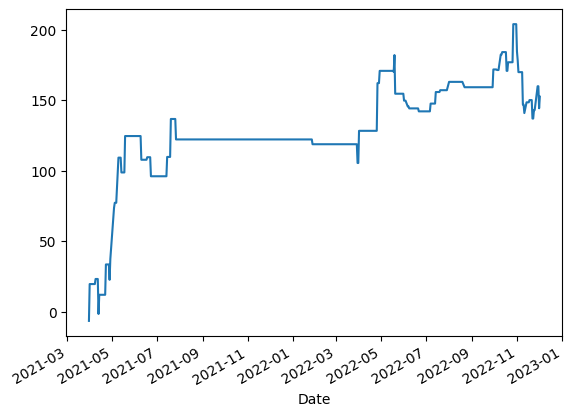

In [80]:
pnl.resample("D").last().dropna().plot()

<AxesSubplot:>

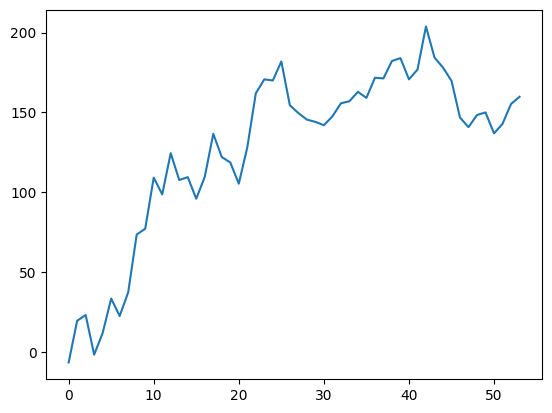

In [81]:
pd.Series(profit).cumsum().plot()

In [53]:
pd.Series(profit).min()

-34.299999999999955

In [54]:
d = 0
a = 0
for i in profit:
    if i > 0:
        d += 1
    if i < 0:
        a += 1
print('win rate: ', d/(d+a))

win rate:  0.676923076923077


In [55]:
for i in range(12):
    print(profit[-i])

6.900000000000091
-13.100000000000023
13.0
-6.0
-9.700000000000045
-19.399999999999977
-17.5
4.5
27.0
28.5
30.100000000000023
-10.300000000000182
